# GNN embedding learning visualization demo

This notebook is for educational purposes only. Its goal is to visually demonstrate how a Graph Neural Network (GNN) gradually learns meaningful node embeddings in a simple graph.

 It is used a toy graph with synthetic node features, and train a GraphSAGE model in an unsupervised setting, where the objective is to learn node representations that reflect the graph’s structure.

By constraining the embedding space to 2D, we can directly visualize how the embeddings evolve during training and observe how the model captures cluster and connectivity patterns in the graph.

#### Dependencies

In [2]:
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

### Graph data generation

Generate a simple graph with clearly distinct communities of nodes to better appreciate the gnn embedding learning.

In [11]:
# Create simple clustered graph with 2D features
def create_graph_with_random_features(num_clusters=3, nodes_per_cluster=7, feature_dim=2):

    G = nx.Graph()
    cluster_offset = 0
    cluster_labels = []

    # Create clusters and add edges
    for c in range(num_clusters):
        cluster = nx.erdos_renyi_graph(nodes_per_cluster, p=0.8)
        mapping = {n: n + cluster_offset for n in cluster.nodes}
        cluster = nx.relabel_nodes(cluster, mapping)
        G = nx.compose(G, cluster)

        cluster_labels.extend([c] * nodes_per_cluster)
        cluster_offset += nodes_per_cluster

    # Add some inter-cluster edges
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            src = i * nodes_per_cluster + np.random.randint(nodes_per_cluster)
            dst = j * nodes_per_cluster + np.random.randint(nodes_per_cluster)
            G.add_edge(src, dst)

    # Random features initialization (unrelated to clusters)
    num_nodes = num_clusters * nodes_per_cluster
    node_features = np.random.randn(num_nodes, feature_dim)

    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(cluster_labels, dtype=torch.long)

    return G, Data(x=x, edge_index=edge_index), y

### GNN model definition

Define the gnn model composed of 2 GraphSAGE layers. GNN Output is an embedding composed by only 2 features for each graph node (to easily visualize it, sufficient to capture the very simple graph we are working with).

During training, each node updates its embedding by aggregating information from its neighbors using a mean aggregator. As training progresses, the embeddings reflect the graph structure, with nodes in the same cluster forming tight groups in 2D space.

In [12]:
# GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels=2, hidden_channels=8, out_channels=2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # (n_nodes, in_channels) -> (n_nodes, hidden_channels)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # (n_nodes, hidden_channels) -> (n_nodes, out_channels)
        x = self.conv2(x, edge_index)
        return x

#### Loss function

We are working in unsupervised setting since we do not want to use labels to learn the graph communities. Instead, we want to learn them only exploting graph structure (i.e. edges between nodes).

For this purpose, we are gonna use a contrastive loss which will force the model to assign similar embeddings to edge-connected nodes and to assign distant embeddings to non-connected nodes:

In [13]:
def compute_contrastive_loss(pos_scores, neg_scores):
  return - (F.logsigmoid(pos_scores).mean() + F.logsigmoid(-neg_scores).mean())

### Utils

Viz utils and training loop

In [14]:
# Visualization directly with 2D features/embeddings
def visualize_2d(z, epoch, labels, title_prefix="Node Embeddings"):
    z = z.detach().cpu().numpy()

    plt.clf()
    scatter = plt.scatter(z[:, 0], z[:, 1], c=labels.cpu().numpy(), cmap='tab10', s=100, edgecolors='k')
    for i, (x_, y_) in enumerate(z):
        plt.text(x_, y_, str(i), fontsize=8, ha='center', va='center', color='black')
    plt.title(f"{title_prefix} at Epoch {epoch}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.pause(0.3)

# Final visualization of original graph and final embedding learned by model
def visualize_graph_vs_embeddings(G, labels, final_embeddings):

    labels_np = labels.cpu().numpy()
    emb_np = final_embeddings.detach().cpu().numpy()

    # Precompute fixed graph layout positions
    graph_pos = nx.spring_layout(G, seed=42)

    if graph_pos is None:
        graph_pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 5))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot original graph structure
    nx.draw(
        G,
        pos=graph_pos,
        ax=ax1,
        node_color=labels_np,
        cmap='tab10',
        with_labels=True,
        node_size=300,
        edge_color='gray',
        font_color='black'
    )
    ax1.set_title("Original Graph (colored by true cluster)")

    # Plot final learned embeddings
    scatter = ax2.scatter(
        emb_np[:, 0], emb_np[:, 1],
        c=labels_np,
        cmap='tab10',
        s=100,
        edgecolors='k'
    )
    for i, (x_, y_) in enumerate(emb_np):
        ax2.text(x_, y_, str(i), fontsize=8, ha='center', va='center', color='black')
    ax2.set_title("Learned Node Embeddings (2D)")
    ax2.set_xlabel("Embedding dim 1")
    ax2.set_ylabel("Embedding dim 2")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Smoothing for loss plot
def smooth_curve(values, window_size=5):
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# Training loop and visualization
def train_and_visualize(epochs=100):
    loss_history = []

    plt.ion()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        z = model(data.x, data.edge_index)

        pos_edge_index = data.edge_index
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        )

        pos_scores = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_scores = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

        loss = compute_contrastive_loss(pos_scores, neg_scores)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")
            model.eval()
            with torch.no_grad():
                z = model(data.x, data.edge_index)
            visualize_2d(z, epoch, labels)

    plt.ioff()
    plt.show()

    # Show raw features + graph before training
    final_embeddings = z
    visualize_graph_vs_embeddings(G, labels, final_embeddings)

    # Plot loss history
    smoothed_loss = smooth_curve(loss_history, window_size=5)
    plt.figure()
    plt.plot(loss_history, alpha=0.3, label="Raw Loss")
    plt.plot(range(len(smoothed_loss)), smoothed_loss, label="Smoothed Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss History (Smoothed)")
    plt.grid(True)
    plt.legend()
    plt.show()

### Visualization demo

Run the cell below to watch the GNN embeddings evolve in real time!

Note: Due to random initialization, each run will produce a unique embedding trajectory.

Epoch 000, Loss: 1.3938


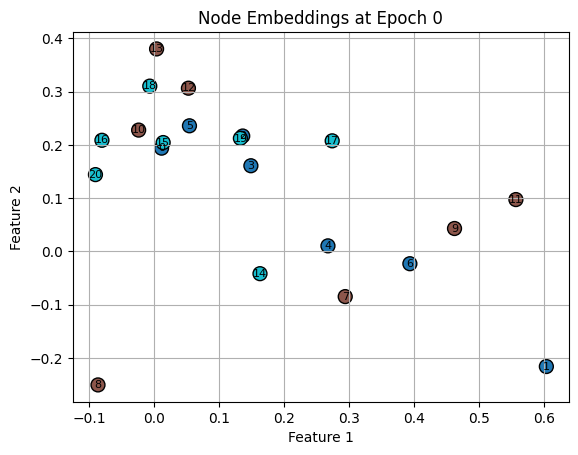

Epoch 050, Loss: 1.0400


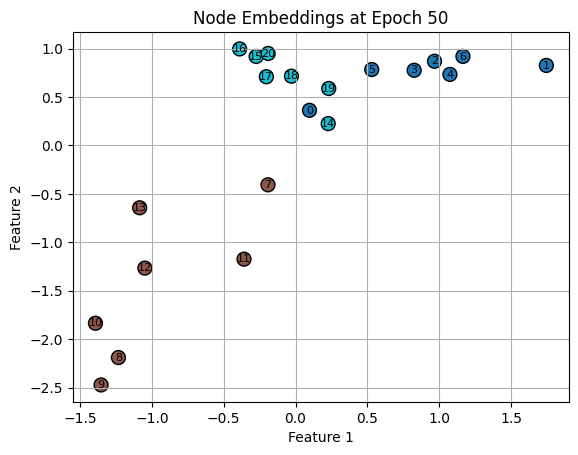

Epoch 100, Loss: 0.9387


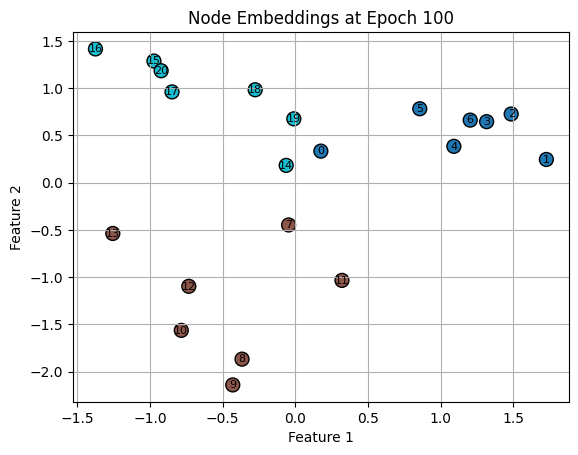

Epoch 150, Loss: 0.8182


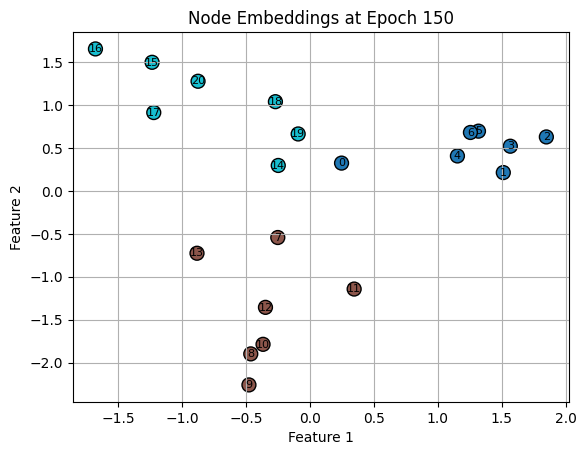

Epoch 200, Loss: 0.8528


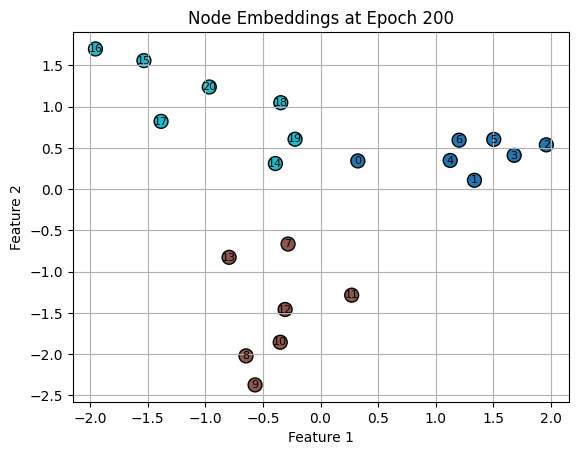

Epoch 250, Loss: 0.9725


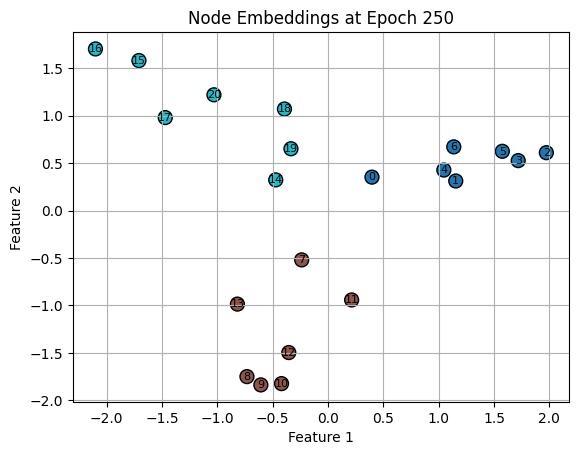

Epoch 300, Loss: 0.9436


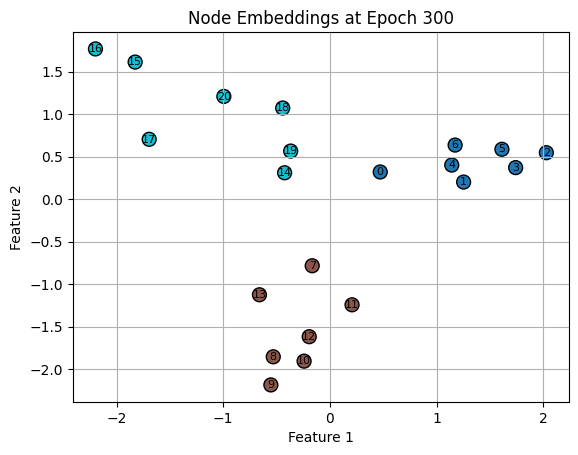

Epoch 350, Loss: 0.8425


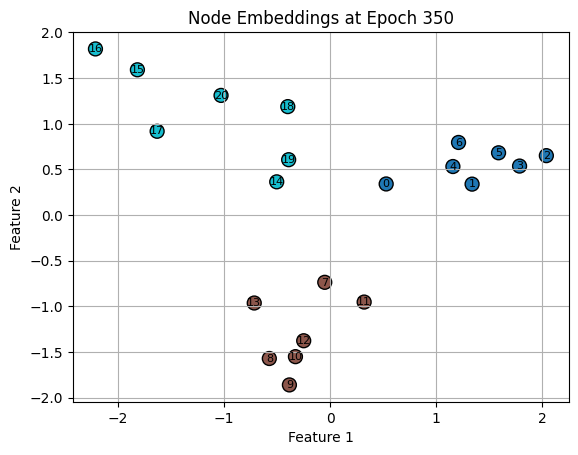

Epoch 400, Loss: 0.7998


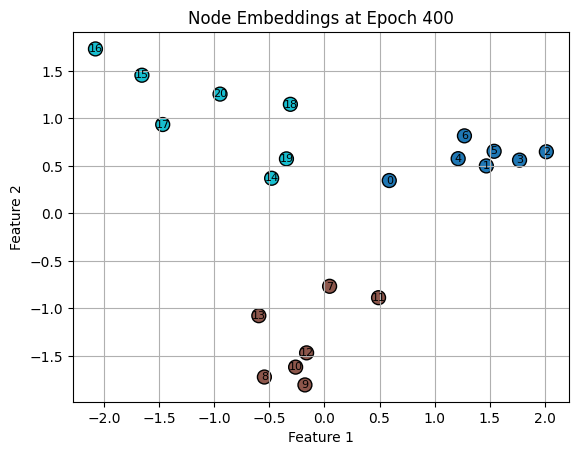

Epoch 450, Loss: 0.8353


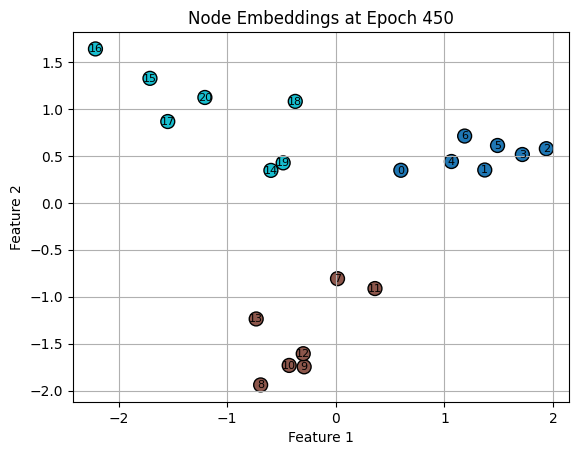

Epoch 500, Loss: 0.9144


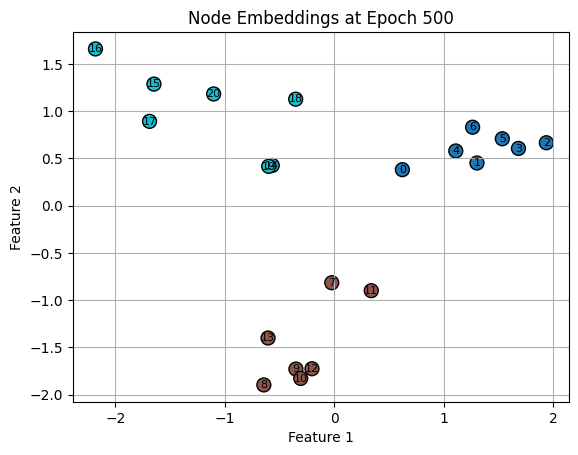

Epoch 550, Loss: 1.0283


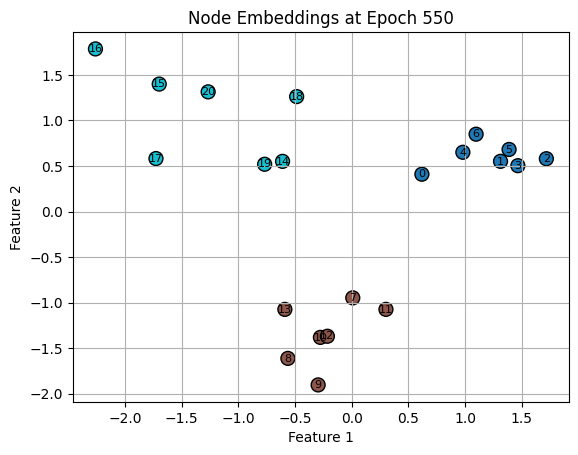

Epoch 600, Loss: 0.7858


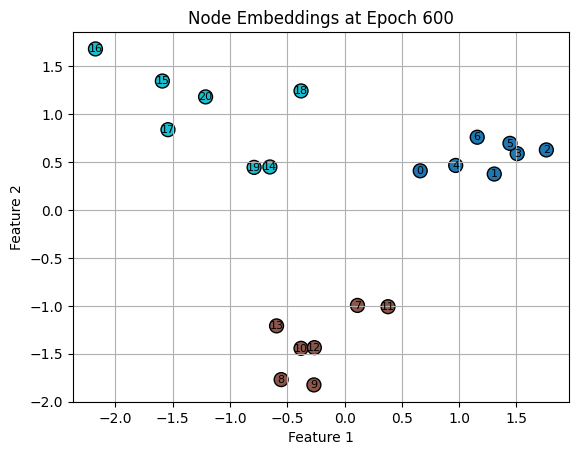

Epoch 650, Loss: 0.8838


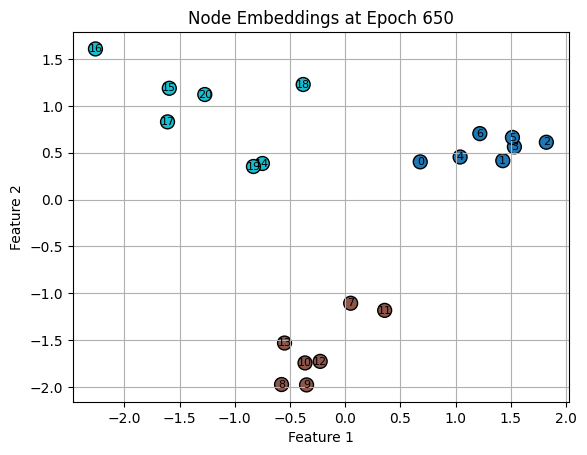

Epoch 700, Loss: 0.8735


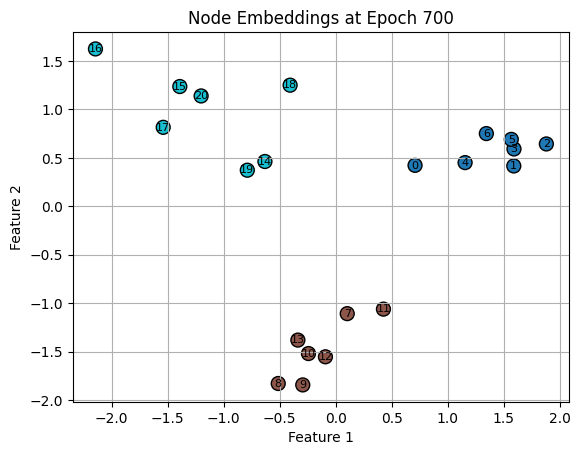

Epoch 750, Loss: 0.8585


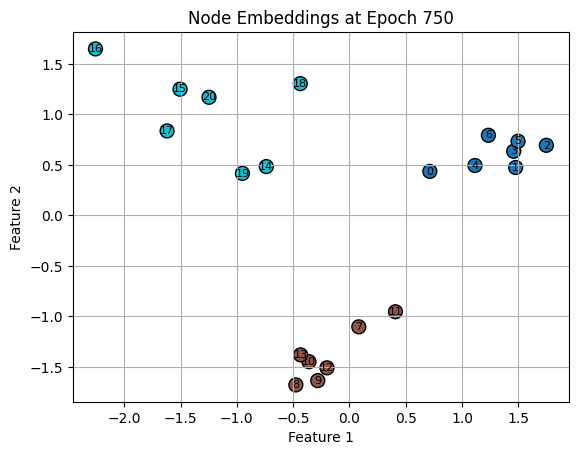

Epoch 800, Loss: 0.9361


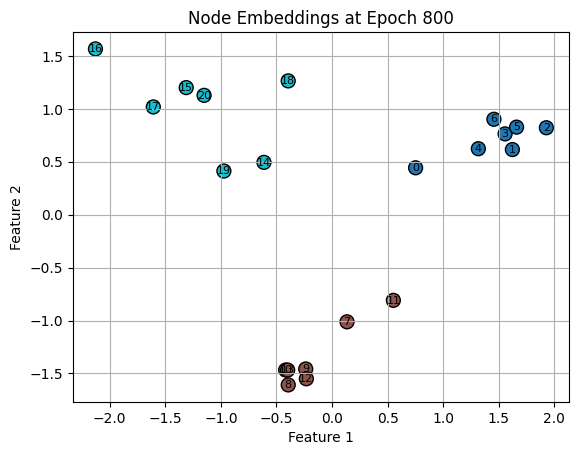

Epoch 850, Loss: 0.8505


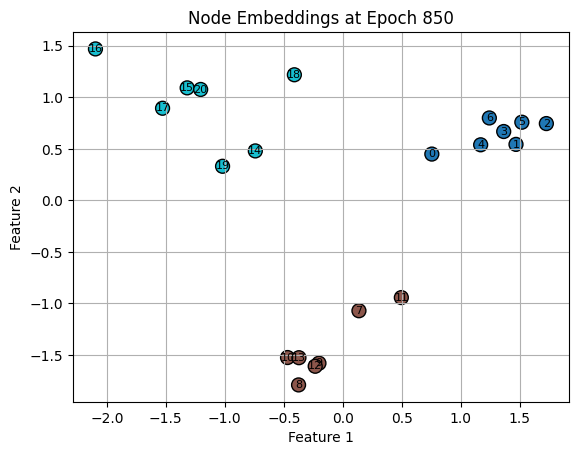

Epoch 900, Loss: 0.8988


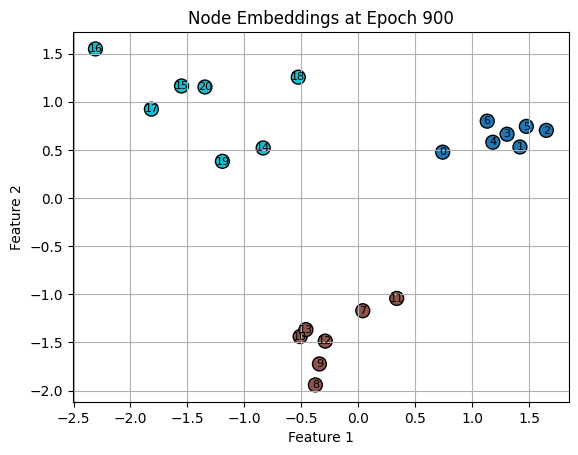

Epoch 950, Loss: 0.9257


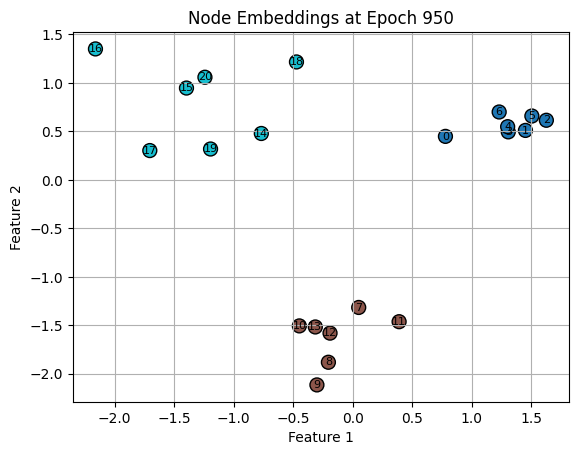

Epoch 1000, Loss: 1.0404


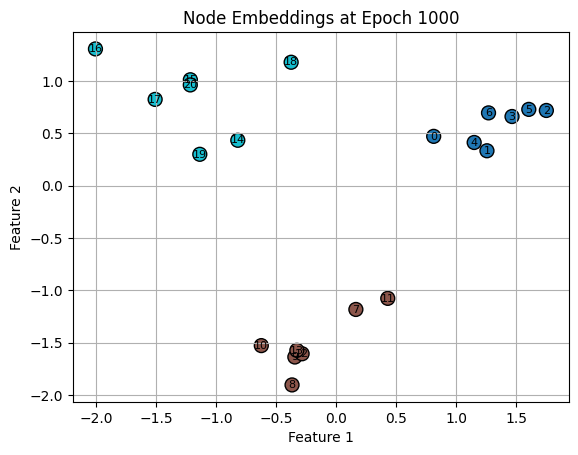

<Figure size 1200x500 with 0 Axes>

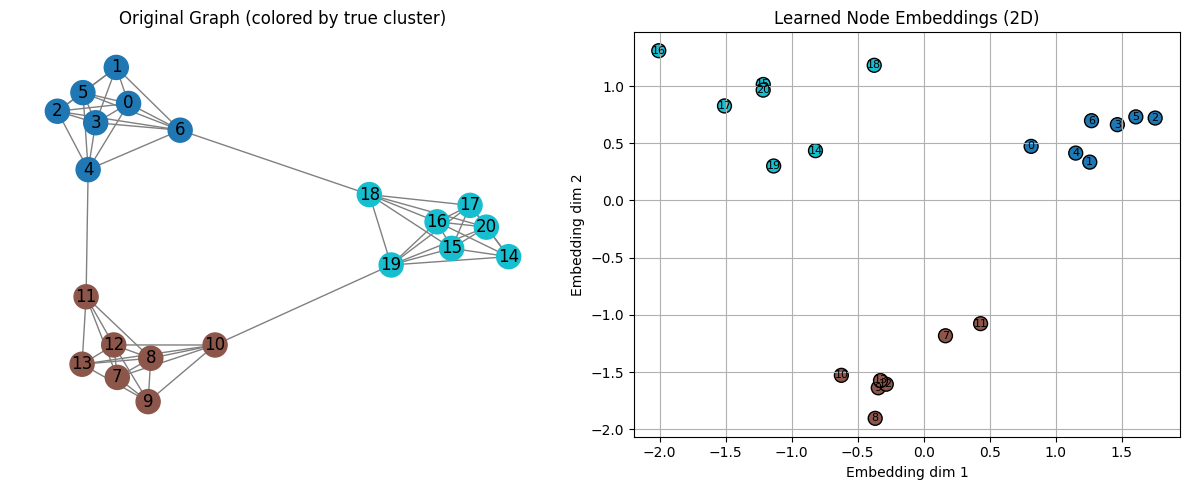

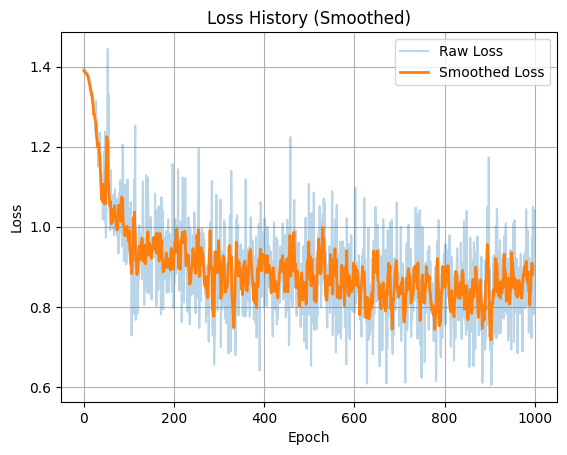

In [19]:
# Generate data
G, data, labels = create_graph_with_random_features(num_clusters=3, nodes_per_cluster=7)

# Instantiate model and its hyperparameters
model = GraphSAGE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

# Train GNN and real-time visualize embedding learning
train_and_visualize(epochs=1001)